In [1]:
import os
os.chdir("../")

In [281]:
import wandb
import torch
import random
import time
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import optim
from tqdm.notebook import tqdm
from models.mobilenetv2 import mobilenetv2
from data.affwild2_dataset import AffWild2ExprDataset
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import StepLR
from typing import Any
from torchvision import datasets
from collections import namedtuple
from torchvision.models import resnet18

In [3]:
%load_ext autoreload
%autoreload 2

# Utility Functions

In [4]:
def random_seed(seed):
    """Set seed"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

def store_params(content, name):
    f = open(f'params/{name}.pkl','wb')
    pickle.dump(content, f)
    f.close()

def load_params(name):
    fl = open(f'params/{name}.pkl', "rb")
    loaded = pickle.load(fl)
    return loaded

def store_model(model, name):
    torch.save(model.state_dict(), f'./trained_models/{name}.pth')
                                

# Data Preparation

In [209]:
project_name = 'moody_much'
cores = 15
random_seed(8)
batch_size = 512
num_classes = 2
skip = 0
input_dim = 112

In [210]:
identity_transform = transforms.Compose([
    transforms.ToTensor()
])

mean = 0.
std = 0.
train_dataset = AffWild2ExprDataset(train=True, skip=skip, remove_mismatch=True, 
                                    compress=True, 
                                    transform=identity_transform, binary=True)

loader = DataLoader(train_dataset, batch_size=batch_size)
for images, _ in tqdm(loader):
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(loader.dataset)
std /= len(loader.dataset)

mean, std

(tensor([0.4722, 0.3625, 0.3350]), tensor([0.2181, 0.1921, 0.1855]))

In [258]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomRotation(30),
    #transforms.RandomResizedCrop((112,112)),
    transforms.RandomHorizontalFlip(0.2),
    transforms.RandomAffine(30),
    #transforms.GaussianBlur((65, 65), sigma=(0.1, 2.0)),
    transforms.Normalize(mean=mean, std=std),
])

transform_valid = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

train_dataset = AffWild2ExprDataset(train=True, skip=skip, remove_mismatch=True,
                                    compress=True, transform=transform_train, binary=True)
valid_dataset = AffWild2ExprDataset(train=False, skip=skip, remove_mismatch=True,
                                    compress=True, transform=transform_valid, binary=True)

In [259]:
len(train_dataset), len(valid_dataset)

(49218, 15266)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


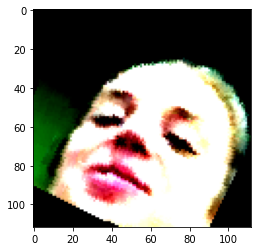

In [260]:
s, l = train_dataset[15003]
s.shape

_ = plt.imshow(s.numpy().transpose(1, 2, 0))

In [261]:
total_valid_num = len(valid_dataset)
total_train_num = len(train_dataset)
valid_num = int(0.5 * total_valid_num)

valid_mask = list(range(valid_num))
test_mask = list(range(valid_num, total_valid_num))

valid_loader = DataLoader(Subset(valid_dataset, valid_mask), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(Subset(valid_dataset, test_mask), batch_size=batch_size, shuffle=True)

small_train_mask = random.sample(range(total_train_num), 500)
medium_train_mask = random.sample(range(total_train_num), 1000)
small_valid_mask = random.sample(range(total_valid_num), 200)

small_train_loader = DataLoader(Subset(train_dataset, list(small_train_mask)), batch_size=batch_size, 
                                shuffle=True, num_workers=2)
small_valid_loader = DataLoader(Subset(valid_dataset, list(small_valid_mask)), batch_size=batch_size, 
                                shuffle=True, num_workers=2)

medium_loader = DataLoader(Subset(train_dataset, list(medium_train_mask)), batch_size=batch_size, shuffle=True)

In [42]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Sweep Configuration

In [274]:
sweep_config = {
    'method': 'grid', #grid, random
    'metric': {
      'name': 'valid_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'learning_rate': {
            'values': [0.001, 0.0008, 0.0005]
        },
        'weight_decay': {
            'values': [1e-1, 1e-2, 1e-3]
        },
        'batch_size': {
            'values': [128, 512]
        },
        'optimizer': {
            'values': ['adam', 'sgd']
        }

    }
}

# Training

In [254]:
def evaluate_video(model: nn.Module, data_loader: Any, device: torch.device, comment: str = ""):
    
    model.eval()
    model.to(device)
    
    total_samples = 0
    correct_samples = 0
    total_loss = 0
    loss_history = []

    batch = 128
    count = 0
    with torch.no_grad():
        for (frames, labels) in tqdm(data_loader):
            
            num_frames = frames.shape[1]
            face_frames = frames.squeeze()
            for i in range(num_frames // batch):
                
                l = batch * i
                r = min(batch * (i + 1), num_frames)
                
                face_batch = face_frames[l:r]
                label = labels[:,l:r].squeeze()
                
                face_batch = face_batch.to(device)
                label = label.to(device)
                
                out = model(face_batch)
                out_prob = F.log_softmax(out, dim=1)
                loss = F.nll_loss(out_prob, label)
                _, pred = torch.max(out_prob, dim=1)

                total_loss += loss.item()
                correct_samples += pred.eq(label).sum()
                count += 1
                total_samples += out_prob.shape[0]
                
    avg_loss = total_loss / count
    wandb.log({'valid_loss': avg_loss})
    accuracy = 100.0 * correct_samples / total_samples
    return accuracy

In [22]:
def train_video():
    
    config_defaults = {
        'epochs': 8,
        'batch_size': 128,
        'learning_rate': 0.0004,
        'optimizer': 'adam',
        'weight_decay': 4e-5,
        'decay_step': 20,
        'decay_gamma': 0.1,
        'input_dim': input_dim,
        'num_classes': num_classes,
    }
    
    universal_id = random.randint(1, 100000)
    
    wandb.init(config=config_defaults)
    #config = namedtuple("Config", config_defaults.keys())(*config_defaults.values())
    config = wandb.config
    
    model = mobilenetv2()
    model.load_state_dict(torch.load('weights/mobilenetv2_128x128-fd66a69d.pth'))
    model.classifier = nn.Linear(model.classifier.in_features, 7)
    
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=cores)
    
    if config.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay, momentum=0.9)
    
    lr_scheduler = StepLR(optimizer, step_size=config.decay_step, gamma=config.decay_gamma)
    
    full_start = time.time()
    for epoch in tqdm(range(config.epochs)):
        
        model.train()
        model.to(device)
        print(f"Starting Epoch {epoch}")
        
        total_loss = 0
        epoch_time = time.time()
        num_batches = 0
        
        batch = 128
        count = 0

        for (frames, labels) in tqdm(small_train_loader):
            
            num_frames = frames.shape[1]
            face_frames = frames.squeeze()
            for i in range(num_frames // batch):
                
                l = batch * i
                r = min(batch * (i + 1), num_frames)
                
                face_batch = face_frames[l:r]
                label = labels[:,l:r].squeeze()
                
                face_batch = face_batch.to(device)
                label = label.to(device)
                
                optimizer.zero_grad()
                
                out = model(face_batch)
                out_prob = F.log_softmax(out, dim=1)
                loss = F.nll_loss(out_prob, label)
                _, pred = torch.max(out_prob, dim=1)
                
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
                count += 1
                
                wandb.log({'batch_loss': loss.item()})
                
        print(f"Finished Epoch {i}")
        
        valid_accuracy = evaluate_video(model, small_valid_loader, device)
        train_accuracy = evaluate_video(model, small_train_loader, device)
        
        print(f"Validation Accuracy: ", valid_accuracy)
        print(f"Training Accuracy: ", train_accuracy)
        
        if i % 3 == 0:
            torch.save(model.state_dict(), f'trained_models/mobilenetv2_hyperparam_{universal_id}.pth')
        
        wandb.log({
            'loss': total_loss / count,
            'valid_accuracy': valid_accuracy,
            'train_accuracy': train_accuracy,
            'epoch_time_minutes': (time.time() - epoch_time) / 60
        })
        
        lr_scheduler.step()
    
    wandb.log({'full_run_time_minutes': (time.time() - full_start) / 60, 'universal_id':universal_id})
        

In [90]:
def evaluate(model: nn.Module, data_loader: Any, device: torch.device, comment: str = ""):
    
    model.eval()
    
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0
    loss_history = []

    with torch.no_grad():
        for data, target in tqdm(data_loader):
            data = data.to(device)
            target = target.to(device)
            
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)

            total_loss += loss.item()
            correct_samples += pred.eq(target).sum()
    
    avg_loss = total_loss / total_samples
    if comment == "val":
        wandb.log({'valid_loss': avg_loss})
    
    accuracy = 100.0 * correct_samples / total_samples
    return accuracy

In [283]:
def train():
    
    config_defaults = {
        'epochs': 8,
        'batch_size': batch_size,
        'learning_rate': 0.0004,
        'optimizer': 'adam',
        'weight_decay': 4e-5,
        'decay_step': 7,
        'decay_gamma': 0.1,
        'input_dim': input_dim,
        'num_classes': num_classes,
    }
    
    universal_id = random.randint(1, 100000)
    
    wandb.init(config=config_defaults)
    #config = namedtuple("Config", config_defaults.keys())(*config_defaults.values())
    config = wandb.config
    
    #model = mobilenetv2()
    # model.load_state_dict(torch.load('weights/mobilenetv2_128x128-fd66a69d.pth'))
    #model.load_state_dict(torch.load('weights/mobilenetv2_192x192-e423d99e.pth'))
    #model.classifier = nn.Linear(model.classifier.in_features, config.num_classes)
    model = resnet18(num_classes=2)
    
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=cores)
    
    if config.optimizer == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    else:
        optimizer = optim.SGD(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay, momentum=0.9)
    
    lr_scheduler = StepLR(optimizer, step_size=config.decay_step, gamma=config.decay_gamma)
    
    full_start = time.time()
    for i in tqdm(range(config.epochs)):
        
        model.train()
        model.to(device)
        print(f"Starting Epoch {i}")
        
        total_loss = 0
        epoch_time = time.time()
        num_batches = 0
        for data, label in tqdm(train_loader):
            
            data, label = data.to(device), label.to(device)
            optimizer.zero_grad()
            
            out = model(data)
            output = F.log_softmax(out, dim=1)
            loss = F.nll_loss(output, label)
            loss.backward()
            
            total_loss += loss.item()
            optimizer.step()
            num_batches += 1
            
            wandb.log({'batch_loss': loss.item()})
        print(f"Finished Epoch {i}")
        
        valid_accuracy = evaluate(model, valid_loader, device, "val")
        train_accuracy = evaluate(model, train_loader, device)
        
        print(f"Validation Accuracy: ", valid_accuracy)
        print(f"Training Accuracy: ", train_accuracy)
        
        if i % 3 == 0:
            torch.save(model.state_dict(), f'trained_models/mobilenetv2_hyper_{universal_id}.pth')
        
        wandb.log({
            'loss': total_loss / num_batches,
            'valid_accuracy': valid_accuracy,
            'train_accuracy': train_accuracy,
            'epoch_time_minutes': (time.time() - epoch_time) / 60
        })
        
        lr_scheduler.step()
        
    torch.save(model.state_dict(), f'trained_models/mobilenetv2_hyper_{universal_id}.pth')
    test_accuracy = evaluate(model, test_loader, device)
    wandb.log({
        'full_run_time_minutes': (time.time() - full_start) / 60, 
        'universal_id':universal_id,
        'test_accuracy':test_accuracy
    })
        

# Initialize Sweep 

In [284]:
sweep_id = wandb.sweep(sweep_config, project=project_name)

Create sweep with ID: chq8v0u6
Sweep URL: https://wandb.ai/nazirnayal98/moody_much/sweeps/chq8v0u6


# Run Sweep

In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: veil9vd0 with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.1


Starting Epoch 0



Finished Epoch 0



Validation Accuracy:  tensor(40.6917, device='cuda:0')
Training Accuracy:  tensor(77.6484, device='cuda:0')
Starting Epoch 1



Finished Epoch 1



Validation Accuracy:  tensor(48.9978, device='cuda:0')
Training Accuracy:  tensor(57.5785, device='cuda:0')
Starting Epoch 2



Finished Epoch 2



Validation Accuracy:  tensor(51.1332, device='cuda:0')
Training Accuracy:  tensor(57.7776, device='cuda:0')
Starting Epoch 3



Finished Epoch 3



Validation Accuracy:  tensor(62.9241, device='cuda:0')
Training Accuracy:  tensor(85.2757, device='cuda:0')
Starting Epoch 4



Finished Epoch 4



Validation Accuracy:  tensor(53.0853, device='cuda:0')
Training Accuracy:  tensor(82.3459, device='cuda:0')
Starting Epoch 5



Finished Epoch 5



Validation Accuracy:  tensor(42.0542, device='cuda:0')
Training Accuracy:  tensor(84.5951, device='cuda:0')
Starting Epoch 6



Finished Epoch 6



Validation Accuracy:  tensor(59.4917, device='cuda:0')
Training Accuracy:  tensor(95.0364, device='cuda:0')
Starting Epoch 7



Finished Epoch 7



Validation Accuracy:  tensor(60.8542, device='cuda:0')
Training Accuracy:  tensor(96.5439, device='cuda:0')



batch_loss,0.15494
_runtime,765
_timestamp,1616941073
_step,3096
valid_loss,0.85026
loss,0.16581
valid_accuracy,60.85419
train_accuracy,96.54395
epoch_time_minutes,1.54111
full_run_time_minutes,12.62544
universal_id,88971


batch_loss,▆▄▆▇▆▃▅▂▄▆▆▇▅▄▅▇▃█▄▃▅▄▅▄▃▄▅▄▄▃▄▂▄▂▃▂▃▂▁▂
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,▄▂█▂▂▆▁▂
loss,█▇▇▆▅▄▃▁
valid_accuracy,▁▄▄█▅▁▇▇
train_accuracy,▅▁▁▆▅▆██
epoch_time_minutes,▇█▅▅▄▁▇▃
full_run_time_minutes,▁
universal_id,▁


wandb: Agent Starting Run: e6on44ht with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.01


Starting Epoch 0



Finished Epoch 0



Validation Accuracy:  tensor(44.0456, device='cuda:0')
Training Accuracy:  tensor(86.6167, device='cuda:0')
Starting Epoch 1



Finished Epoch 1



Validation Accuracy:  tensor(50.5044, device='cuda:0')
Training Accuracy:  tensor(79.4262, device='cuda:0')
Starting Epoch 2



Finished Epoch 2



Validation Accuracy:  tensor(51.0546, device='cuda:0')
Training Accuracy:  tensor(87.6651, device='cuda:0')
Starting Epoch 3



Finished Epoch 3



Validation Accuracy:  tensor(76.3527, device='cuda:0')
Training Accuracy:  tensor(93.1245, device='cuda:0')
Starting Epoch 4



Finished Epoch 4



Validation Accuracy:  tensor(49.7052, device='cuda:0')
Training Accuracy:  tensor(54.9453, device='cuda:0')
Starting Epoch 5



Finished Epoch 5



Validation Accuracy:  tensor(47.0981, device='cuda:0')
Training Accuracy:  tensor(83.0184, device='cuda:0')
Starting Epoch 6



Finished Epoch 6



Validation Accuracy:  tensor(52.0765, device='cuda:0')
Training Accuracy:  tensor(92.9761, device='cuda:0')
Starting Epoch 7



Finished Epoch 7



Validation Accuracy:  tensor(63.5661, device='cuda:0')
Training Accuracy:  tensor(98.3258, device='cuda:0')



batch_loss,0.10504
_runtime,763
_timestamp,1616941840
_step,3096
valid_loss,1.02001
loss,0.06536
valid_accuracy,63.5661
train_accuracy,98.32581
epoch_time_minutes,1.51651
full_run_time_minutes,12.6138
universal_id,34976


batch_loss,█▇▇▃▃▃▅▆█▄▅▆▄▃█▂▄▄▆▄▃▄▅▂▃▅▃▅▃▄▃▃▅▃▁▅▃▂▂▂
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,▆█▂▁▄▅▇▃
loss,█▇▆▅▅▃▃▁
valid_accuracy,▁▂▃█▂▂▃▅
train_accuracy,▆▅▆▇▁▆▇█
epoch_time_minutes,▇█▄▅▅▇▅▁
full_run_time_minutes,▁
universal_id,▁


wandb: Agent Starting Run: hndovyha with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001


Starting Epoch 0



Finished Epoch 0



Validation Accuracy:  tensor(60.2515, device='cuda:0')
Training Accuracy:  tensor(95.8369, device='cuda:0')
Starting Epoch 1



Finished Epoch 1



Validation Accuracy:  tensor(68.1908, device='cuda:0')
Training Accuracy:  tensor(95.4102, device='cuda:0')
Starting Epoch 2



Finished Epoch 2



Validation Accuracy:  tensor(54.4609, device='cuda:0')
Training Accuracy:  tensor(97.0803, device='cuda:0')
Starting Epoch 3



Finished Epoch 3



Validation Accuracy:  tensor(66.6186, device='cuda:0')
Training Accuracy:  tensor(97.0417, device='cuda:0')
Starting Epoch 4



Finished Epoch 4



Validation Accuracy:  tensor(73.7980, device='cuda:0')
Training Accuracy:  tensor(95.9446, device='cuda:0')
Starting Epoch 5



Finished Epoch 5



Validation Accuracy:  tensor(65.6885, device='cuda:0')
Training Accuracy:  tensor(97.8727, device='cuda:0')
Starting Epoch 6



Finished Epoch 6



Validation Accuracy:  tensor(56.6357, device='cuda:0')
Training Accuracy:  tensor(97.8646, device='cuda:0')
Starting Epoch 7



Finished Epoch 7



Validation Accuracy:  tensor(62.5180, device='cuda:0')
Training Accuracy:  tensor(99.1751, device='cuda:0')



batch_loss,0.06716
_runtime,764
_timestamp,1616942609
_step,3096
valid_loss,1.25748
loss,0.03317
valid_accuracy,62.51802
train_accuracy,99.17509
epoch_time_minutes,1.53954
full_run_time_minutes,12.63219
universal_id,96202


batch_loss,█▆█▃▅▇▃▅▃▂▃▃▅▅▅█▂▄▄▃▃▁▅▂▂▅▃▃▃▂▂▃▃▂▁▂▂▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,█▂█▇▁▃▆█
loss,█▅▄▄▄▃▃▁
valid_accuracy,▃▆▁▅█▅▂▄
train_accuracy,▂▁▄▄▂▆▆█
epoch_time_minutes,▆▅▄█▄▄▁▃
full_run_time_minutes,▁
universal_id,▁


wandb: Agent Starting Run: 1ajnm4l4 with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.1


Starting Epoch 0



Finished Epoch 0



Validation Accuracy:  tensor(52.6923, device='cuda:0')
Training Accuracy:  tensor(90.3125, device='cuda:0')
Starting Epoch 1



Finished Epoch 1



Validation Accuracy:  tensor(52.0241, device='cuda:0')
Training Accuracy:  tensor(95.1583, device='cuda:0')
Starting Epoch 2



Finished Epoch 2



Validation Accuracy:  tensor(53.6093, device='cuda:0')
Training Accuracy:  tensor(94.0245, device='cuda:0')
Starting Epoch 3



Finished Epoch 3



Validation Accuracy:  tensor(55.8889, device='cuda:0')
Training Accuracy:  tensor(92.3361, device='cuda:0')
Starting Epoch 4



Finished Epoch 4



Validation Accuracy:  tensor(54.7360, device='cuda:0')
Training Accuracy:  tensor(90.8834, device='cuda:0')
Starting Epoch 5



Finished Epoch 5



Validation Accuracy:  tensor(64.9286, device='cuda:0')
Training Accuracy:  tensor(97.7529, device='cuda:0')
Starting Epoch 6



Finished Epoch 6



Validation Accuracy:  tensor(70.2869, device='cuda:0')
Training Accuracy:  tensor(96.0096, device='cuda:0')
Starting Epoch 7



Finished Epoch 7



Validation Accuracy:  tensor(75.4094, device='cuda:0')
Training Accuracy:  tensor(99.5205, device='cuda:0')



batch_loss,0.06396
_runtime,749
_timestamp,1616943363
_step,3096
valid_loss,0.50853
loss,0.07269
valid_accuracy,75.40941
train_accuracy,99.5205
epoch_time_minutes,1.51583
full_run_time_minutes,12.3761
universal_id,17858


batch_loss,█▄▃▂▂▁▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▂▂▁▂▂▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,▇█▅▇▇▃▂▁
loss,█▂▁▁▁▁▂▁
valid_accuracy,▁▁▁▂▂▅▆█
train_accuracy,▁▅▄▃▁▇▅█
epoch_time_minutes,▇▇▇▅█▆▁▄
full_run_time_minutes,▁
universal_id,▁


wandb: Agent Starting Run: wldevktv with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.01


Starting Epoch 0



Finished Epoch 0



Validation Accuracy:  tensor(54.8932, device='cuda:0')
Training Accuracy:  tensor(96.1985, device='cuda:0')
Starting Epoch 1



Finished Epoch 1



Validation Accuracy:  tensor(65.0989, device='cuda:0')
Training Accuracy:  tensor(97.7386, device='cuda:0')
Starting Epoch 2



Finished Epoch 2



Validation Accuracy:  tensor(58.2209, device='cuda:0')
Training Accuracy:  tensor(97.4461, device='cuda:0')
Starting Epoch 3



Finished Epoch 3



Validation Accuracy:  tensor(59.6096, device='cuda:0')
Training Accuracy:  tensor(98.3360, device='cuda:0')
Starting Epoch 4



Finished Epoch 4



Validation Accuracy:  tensor(59.4917, device='cuda:0')
Training Accuracy:  tensor(99.0491, device='cuda:0')
Starting Epoch 5



Finished Epoch 5



Validation Accuracy:  tensor(63.2124, device='cuda:0')
Training Accuracy:  tensor(98.6956, device='cuda:0')
Starting Epoch 6



Finished Epoch 6



Validation Accuracy:  tensor(66.0160, device='cuda:0')
Training Accuracy:  tensor(99.1670, device='cuda:0')
Starting Epoch 7



Finished Epoch 7



Validation Accuracy:  tensor(69.6712, device='cuda:0')
Training Accuracy:  tensor(99.5388, device='cuda:0')



batch_loss,0.01243
_runtime,751
_timestamp,1616944118
_step,3096
valid_loss,1.04778
loss,0.01974
valid_accuracy,69.67117
train_accuracy,99.53879
epoch_time_minutes,1.54666
full_run_time_minutes,12.39138
universal_id,45506


batch_loss,█▄▄▂▂▃▂▂▁▂▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▂▂▂▁▂▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,▂▁██▇▅▆▄
loss,█▃▂▂▂▁▁▁
valid_accuracy,▁▆▃▃▃▅▆█
train_accuracy,▁▄▄▅▇▆▇█
epoch_time_minutes,▄▁▁▃▁▂▅█
full_run_time_minutes,▁
universal_id,▁


wandb: Agent Starting Run: z6fm719m with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


Starting Epoch 0



Finished Epoch 0



Validation Accuracy:  tensor(58.8890, device='cuda:0')
Training Accuracy:  tensor(88.6464, device='cuda:0')
Starting Epoch 1



Finished Epoch 1



Validation Accuracy:  tensor(60.7494, device='cuda:0')
Training Accuracy:  tensor(98.0556, device='cuda:0')
Starting Epoch 2



Finished Epoch 2



Validation Accuracy:  tensor(60.5529, device='cuda:0')
Training Accuracy:  tensor(98.7647, device='cuda:0')
Starting Epoch 3



Finished Epoch 3



Validation Accuracy:  tensor(65.4657, device='cuda:0')
Training Accuracy:  tensor(98.7748, device='cuda:0')
Starting Epoch 4



Finished Epoch 4



Validation Accuracy:  tensor(61.8630, device='cuda:0')
Training Accuracy:  tensor(99.0369, device='cuda:0')
Starting Epoch 5



Finished Epoch 5



Validation Accuracy:  tensor(63.8150, device='cuda:0')
Training Accuracy:  tensor(99.2218, device='cuda:0')
Starting Epoch 6



Finished Epoch 6



Validation Accuracy:  tensor(64.5487, device='cuda:0')
Training Accuracy:  tensor(98.9760, device='cuda:0')
Starting Epoch 7



Finished Epoch 7



Validation Accuracy:  tensor(65.5312, device='cuda:0')
Training Accuracy:  tensor(99.5591, device='cuda:0')



batch_loss,0.00254
_runtime,756
_timestamp,1616944878
_step,3096
valid_loss,1.17571
loss,0.01843
valid_accuracy,65.53125
train_accuracy,99.5591
epoch_time_minutes,1.54535
full_run_time_minutes,12.49294
universal_id,81092


batch_loss,█▄▂▃▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▂▁▂▁▁▁▂▂▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,▄▃▅▁▄█▃▄
loss,█▃▂▂▂▁▁▁
valid_accuracy,▁▃▃█▄▆▇█
train_accuracy,▁▇▇▇████
epoch_time_minutes,▇▁▃▅▆▆▆█
full_run_time_minutes,▁
universal_id,▁


wandb: Agent Starting Run: go7i2v5t with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0008
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.1


Starting Epoch 0



Finished Epoch 0



Validation Accuracy:  tensor(51.9062, device='cuda:0')
Training Accuracy:  tensor(78.3209, device='cuda:0')
Starting Epoch 1



Finished Epoch 1



Validation Accuracy:  tensor(49.8493, device='cuda:0')
Training Accuracy:  tensor(78.8817, device='cuda:0')
Starting Epoch 2



Finished Epoch 2



Validation Accuracy:  tensor(54.1858, device='cuda:0')
Training Accuracy:  tensor(88.2685, device='cuda:0')
Starting Epoch 3



Finished Epoch 3



Validation Accuracy:  tensor(50.1114, device='cuda:0')
Training Accuracy:  tensor(52.4950, device='cuda:0')
Starting Epoch 4



Finished Epoch 4



Validation Accuracy:  tensor(53.5045, device='cuda:0')
Training Accuracy:  tensor(84.3452, device='cuda:0')
Starting Epoch 5



Finished Epoch 5



Validation Accuracy:  tensor(52.5612, device='cuda:0')
Training Accuracy:  tensor(85.3895, device='cuda:0')
Starting Epoch 6



Finished Epoch 6



Validation Accuracy:  tensor(57.0942, device='cuda:0')
Training Accuracy:  tensor(94.2216, device='cuda:0')
Starting Epoch 7



Finished Epoch 7



Validation Accuracy:  tensor(63.8281, device='cuda:0')
Training Accuracy:  tensor(95.9832, device='cuda:0')



batch_loss,0.1748
_runtime,768
_timestamp,1616945651
_step,3096
valid_loss,0.70621
loss,0.18999
valid_accuracy,63.82812
train_accuracy,95.98318
epoch_time_minutes,1.52697
full_run_time_minutes,12.69601
universal_id,98454


batch_loss,▂▅▄▁▃▅▅▂▂▄▁▇▂▆█▄▃▂▄▂▁▃▂▅▂▄▅▄▂▃▂▂▃▃▂▂▁▃▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,▅▂█▂▂▁▄▁
loss,█▆▆▅▅▆▅▁
valid_accuracy,▂▁▃▁▃▂▅█
train_accuracy,▅▅▇▁▆▆██
epoch_time_minutes,█▅▇▇▆▆▆▁
full_run_time_minutes,▁
universal_id,▁


wandb: Agent Starting Run: f7uqtcxk with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0008
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.01


Starting Epoch 0



Finished Epoch 0



Validation Accuracy:  tensor(59.1118, device='cuda:0')
Training Accuracy:  tensor(95.4509, device='cuda:0')
Starting Epoch 1



Finished Epoch 1



Validation Accuracy:  tensor(69.4484, device='cuda:0')
Training Accuracy:  tensor(84.6337, device='cuda:0')
Starting Epoch 2



Finished Epoch 2



Validation Accuracy:  tensor(67.6274, device='cuda:0')
Training Accuracy:  tensor(93.0655, device='cuda:0')
Starting Epoch 3



Finished Epoch 3



Validation Accuracy:  tensor(59.8847, device='cuda:0')
Training Accuracy:  tensor(94.9714, device='cuda:0')
Starting Epoch 4



Finished Epoch 4



Validation Accuracy:  tensor(64.5356, device='cuda:0')
Training Accuracy:  tensor(83.1139, device='cuda:0')
Starting Epoch 5



Finished Epoch 5



Validation Accuracy:  tensor(70.8110, device='cuda:0')
Training Accuracy:  tensor(90.1276, device='cuda:0')
Starting Epoch 6



Finished Epoch 6



Validation Accuracy:  tensor(65.9112, device='cuda:0')
Training Accuracy:  tensor(87.6976, device='cuda:0')
Starting Epoch 7



Finished Epoch 7



Validation Accuracy:  tensor(67.0248, device='cuda:0')
Training Accuracy:  tensor(97.9743, device='cuda:0')



batch_loss,0.1358
_runtime,763
_timestamp,1616946418
_step,3096
valid_loss,0.90611
loss,0.07039
valid_accuracy,67.02477
train_accuracy,97.97432
epoch_time_minutes,1.53574
full_run_time_minutes,12.59875
universal_id,20973


batch_loss,▅▅▇▇▆▆▅▆▄█▇▃▅▅▅▇▅▇▇▃▄▆▆▆▄▄▃▅▆▅▄▄▂▂▄▃▃▂▁▄
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,█▁▂█▃▄▃▇
loss,█▇▆▅▅▅▃▁
valid_accuracy,▁▇▆▁▄█▅▆
train_accuracy,▇▂▆▇▁▄▃█
epoch_time_minutes,▅█▃▃▂▁▃▂
full_run_time_minutes,▁
universal_id,▁


wandb: Agent Starting Run: vgozyhma with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0008
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001


Starting Epoch 0



Finished Epoch 0



Validation Accuracy:  tensor(65.8588, device='cuda:0')
Training Accuracy:  tensor(92.5576, device='cuda:0')
Starting Epoch 1



Finished Epoch 1



Validation Accuracy:  tensor(77.6628, device='cuda:0')
Training Accuracy:  tensor(94.5386, device='cuda:0')
Starting Epoch 2



Finished Epoch 2



Validation Accuracy:  tensor(55.3125, device='cuda:0')
Training Accuracy:  tensor(96.0665, device='cuda:0')
Starting Epoch 3



Finished Epoch 3



Validation Accuracy:  tensor(75.2260, device='cuda:0')
Training Accuracy:  tensor(91.2146, device='cuda:0')
Starting Epoch 4



Finished Epoch 4



Validation Accuracy:  tensor(73.7063, device='cuda:0')
Training Accuracy:  tensor(97.3546, device='cuda:0')
Starting Epoch 5



Finished Epoch 5



Validation Accuracy:  tensor(73.0905, device='cuda:0')
Training Accuracy:  tensor(96.6313, device='cuda:0')
Starting Epoch 6



Finished Epoch 6



Validation Accuracy:  tensor(77.9117, device='cuda:0')
Training Accuracy:  tensor(98.3685, device='cuda:0')
Starting Epoch 7



Finished Epoch 7



Validation Accuracy:  tensor(80.7415, device='cuda:0')
Training Accuracy:  tensor(99.5205, device='cuda:0')



batch_loss,0.00763
_runtime,767
_timestamp,1616947189
_step,3096
valid_loss,0.51785
loss,0.02632
valid_accuracy,80.74152
train_accuracy,99.5205
epoch_time_minutes,1.54681
full_run_time_minutes,12.66775
universal_id,49408


batch_loss,▇▅▄█▆▃▄▃▅▄▅▄▆▃▄▂▃▃▃▃▂▂▂▂▂▂▂▂▄▂▂▂▁▂▁▂▂▃▁▂
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,▃▂█▂▂▂▂▁
loss,█▅▄▄▄▄▃▁
valid_accuracy,▄▇▁▆▆▆▇█
train_accuracy,▂▄▅▁▆▆▇█
epoch_time_minutes,▄▁▃▆▆▆█▃
full_run_time_minutes,▁
universal_id,▁


wandb: Agent Starting Run: nzrc6w2c with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0008
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.1


Starting Epoch 0



Finished Epoch 0



Validation Accuracy:  tensor(47.4126, device='cuda:0')
Training Accuracy:  tensor(95.8816, device='cuda:0')
Starting Epoch 1



Finished Epoch 1



Validation Accuracy:  tensor(54.0941, device='cuda:0')
Training Accuracy:  tensor(96.7248, device='cuda:0')
Starting Epoch 2



Finished Epoch 2



Validation Accuracy:  tensor(60.0812, device='cuda:0')
Training Accuracy:  tensor(95.8958, device='cuda:0')
Starting Epoch 3



Finished Epoch 3



Validation Accuracy:  tensor(55.4566, device='cuda:0')
Training Accuracy:  tensor(98.2222, device='cuda:0')
Starting Epoch 4



Finished Epoch 4



Validation Accuracy:  tensor(65.3085, device='cuda:0')
Training Accuracy:  tensor(98.7078, device='cuda:0')
Starting Epoch 5



Finished Epoch 5



Validation Accuracy:  tensor(69.0292, device='cuda:0')
Training Accuracy:  tensor(98.1003, device='cuda:0')
Starting Epoch 6



Finished Epoch 6



Validation Accuracy:  tensor(63.3041, device='cuda:0')
Training Accuracy:  tensor(88.1771, device='cuda:0')
Starting Epoch 7



Finished Epoch 7



Validation Accuracy:  tensor(70.3000, device='cuda:0')
Training Accuracy:  tensor(99.4311, device='cuda:0')



batch_loss,0.07513
_runtime,755
_timestamp,1616947948
_step,3096
valid_loss,0.57253
loss,0.05955
valid_accuracy,70.30002
train_accuracy,99.4311
epoch_time_minutes,1.53186
full_run_time_minutes,12.4602
universal_id,56892


batch_loss,█▃▂▂▂▂▂▁▂▁▂▁▁▁▁▂▂▁▁▂▁▂▁▁▁▁▁▂▁▂▁▂▂▂▂▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,▄▅█▆▃▅▇▁
loss,█▂▂▁▁▁▂▁
valid_accuracy,▁▃▅▃▆█▆█
train_accuracy,▆▆▆▇█▇▁█
epoch_time_minutes,█▂▄▄▃▁▁▄
full_run_time_minutes,▁
universal_id,▁


wandb: Agent Starting Run: gykzjern with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0008
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.01


Starting Epoch 0



Finished Epoch 0



Validation Accuracy:  tensor(59.2690, device='cuda:0')
Training Accuracy:  tensor(96.0970, device='cuda:0')
Starting Epoch 1



Finished Epoch 1



Validation Accuracy:  tensor(56.3605, device='cuda:0')
Training Accuracy:  tensor(97.2063, device='cuda:0')
Starting Epoch 2



Finished Epoch 2



Validation Accuracy:  tensor(55.0504, device='cuda:0')
Training Accuracy:  tensor(98.2466, device='cuda:0')
Starting Epoch 3



Finished Epoch 3



Validation Accuracy:  tensor(72.3176, device='cuda:0')
Training Accuracy:  tensor(98.8622, device='cuda:0')
Starting Epoch 4



Finished Epoch 4



Validation Accuracy:  tensor(71.4660, device='cuda:0')
Training Accuracy:  tensor(99.0532, device='cuda:0')
Starting Epoch 5



Finished Epoch 5



Validation Accuracy:  tensor(77.2042, device='cuda:0')
Training Accuracy:  tensor(99.2239, device='cuda:0')
Starting Epoch 6



Finished Epoch 6



Validation Accuracy:  tensor(68.6755, device='cuda:0')
Training Accuracy:  tensor(98.9963, device='cuda:0')
Starting Epoch 7



Finished Epoch 7



Validation Accuracy:  tensor(77.2042, device='cuda:0')
Training Accuracy:  tensor(99.4941, device='cuda:0')



batch_loss,0.02482
_runtime,753
_timestamp,1616948707
_step,3096
valid_loss,0.95883
loss,0.0238
valid_accuracy,77.20425
train_accuracy,99.49409
epoch_time_minutes,1.52147
full_run_time_minutes,12.42955
universal_id,10647


batch_loss,█▅▃▃▄▂▂▂▂▂▁▂▂▁▂▂▂▂▂▁▂▁▁▂▁▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,▁▆█▄▃▁▄▂
loss,█▃▂▂▂▁▁▁
valid_accuracy,▂▁▁▆▆█▅█
train_accuracy,▁▃▅▇▇▇▇█
epoch_time_minutes,▅▆██▆▁▄▄
full_run_time_minutes,▁
universal_id,▁


wandb: Agent Starting Run: l8jt9u0g with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0008
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


Starting Epoch 0



Finished Epoch 0



Validation Accuracy:  tensor(57.5265, device='cuda:0')
Training Accuracy:  tensor(95.2863, device='cuda:0')
Starting Epoch 1



Finished Epoch 1



Validation Accuracy:  tensor(56.3212, device='cuda:0')
Training Accuracy:  tensor(97.6939, device='cuda:0')
Starting Epoch 2



Finished Epoch 2



Validation Accuracy:  tensor(58.6925, device='cuda:0')
Training Accuracy:  tensor(98.3868, device='cuda:0')
Starting Epoch 3



Finished Epoch 3



Validation Accuracy:  tensor(62.9635, device='cuda:0')
Training Accuracy:  tensor(98.8988, device='cuda:0')
Starting Epoch 4



Finished Epoch 4



Validation Accuracy:  tensor(63.1207, device='cuda:0')
Training Accuracy:  tensor(99.0288, device='cuda:0')
Starting Epoch 5



Finished Epoch 5



Validation Accuracy:  tensor(59.7799, device='cuda:0')
Training Accuracy:  tensor(99.2889, device='cuda:0')
Starting Epoch 6



Finished Epoch 6



Validation Accuracy:  tensor(59.5310, device='cuda:0')
Training Accuracy:  tensor(99.3051, device='cuda:0')
Starting Epoch 7



Finished Epoch 7



Validation Accuracy:  tensor(62.6621, device='cuda:0')
Training Accuracy:  tensor(99.5246, device='cuda:0')



batch_loss,0.01138
_runtime,746
_timestamp,1616949458
_step,3096
valid_loss,1.43925
loss,0.02084
valid_accuracy,62.66213
train_accuracy,99.52457
epoch_time_minutes,1.51491
full_run_time_minutes,12.33185
universal_id,13836


batch_loss,█▅▄▃▃▃▃▂▃▂▁▂▁▂▂▁▁▁▁▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,▁▃▄▂▂▆█▅
loss,█▃▂▂▂▁▁▁
valid_accuracy,▂▁▃██▅▄█
train_accuracy,▁▅▆▇▇███
epoch_time_minutes,▇▂▃▁▃▄█▅
full_run_time_minutes,▁
universal_id,▁


wandb: Agent Starting Run: 1m7j05ne with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.1


Starting Epoch 0



Finished Epoch 0



Validation Accuracy:  tensor(52.6006, device='cuda:0')
Training Accuracy:  tensor(56.6561, device='cuda:0')
Starting Epoch 1



Finished Epoch 1



Validation Accuracy:  tensor(61.4306, device='cuda:0')
Training Accuracy:  tensor(72.5852, device='cuda:0')
Starting Epoch 2



Finished Epoch 2



Validation Accuracy:  tensor(51.1201, device='cuda:0')
Training Accuracy:  tensor(92.5231, device='cuda:0')
Starting Epoch 3



Finished Epoch 3



Validation Accuracy:  tensor(45.8273, device='cuda:0')
Training Accuracy:  tensor(86.7934, device='cuda:0')
Starting Epoch 4



Finished Epoch 4



Validation Accuracy:  tensor(51.9979, device='cuda:0')
Training Accuracy:  tensor(63.3264, device='cuda:0')
Starting Epoch 5



Finished Epoch 5



Validation Accuracy:  tensor(56.1116, device='cuda:0')
Training Accuracy:  tensor(93.1854, device='cuda:0')
Starting Epoch 6



Finished Epoch 6



Validation Accuracy:  tensor(70.4703, device='cuda:0')
Training Accuracy:  tensor(90.3816, device='cuda:0')
Starting Epoch 7



Finished Epoch 7



Validation Accuracy:  tensor(54.2775, device='cuda:0')
Training Accuracy:  tensor(96.3428, device='cuda:0')



batch_loss,0.09476
_runtime,756
_timestamp,1616950218
_step,3096
valid_loss,0.79136
loss,0.11223
valid_accuracy,54.27748
train_accuracy,96.3428
epoch_time_minutes,1.52867
full_run_time_minutes,12.47736
universal_id,83351


batch_loss,▃▅▅▄▅▄▃▅█▂▄▆▄▇▃▄▄▃▃▄▃▆▃▃█▃▄█▁▂▆▄▄▃▄▂▂▁▃▂
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,█▄▁▃▇▄▁▁
loss,█▇▇▇▇▆▇▁
valid_accuracy,▃▅▃▁▃▄█▃
train_accuracy,▁▄▇▆▂▇▇█
epoch_time_minutes,▆▁▆█▆▇█▄
full_run_time_minutes,▁
universal_id,▁


wandb: Agent Starting Run: eehq2e4u with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.01


Starting Epoch 0



Finished Epoch 0



Validation Accuracy:  tensor(55.7186, device='cuda:0')
Training Accuracy:  tensor(95.3838, device='cuda:0')
Starting Epoch 1



Finished Epoch 1



Validation Accuracy:  tensor(62.8848, device='cuda:0')
Training Accuracy:  tensor(90.6843, device='cuda:0')
Starting Epoch 2



Finished Epoch 2



Validation Accuracy:  tensor(59.4655, device='cuda:0')
Training Accuracy:  tensor(93.7279, device='cuda:0')
Starting Epoch 3



Finished Epoch 3



Validation Accuracy:  tensor(62.5573, device='cuda:0')
Training Accuracy:  tensor(97.0275, device='cuda:0')
Starting Epoch 4



Finished Epoch 4



Validation Accuracy:  tensor(68.5838, device='cuda:0')
Training Accuracy:  tensor(96.3387, device='cuda:0')
Starting Epoch 5



Finished Epoch 5



Validation Accuracy:  tensor(71.4660, device='cuda:0')
Training Accuracy:  tensor(96.9869, device='cuda:0')
Starting Epoch 6



Finished Epoch 6



Validation Accuracy:  tensor(77.8331, device='cuda:0')
Training Accuracy:  tensor(92.7283, device='cuda:0')
Starting Epoch 7



Finished Epoch 7



Validation Accuracy:  tensor(67.2475, device='cuda:0')
Training Accuracy:  tensor(98.7220, device='cuda:0')



batch_loss,0.01607
_runtime,759
_timestamp,1616950981
_step,3096
valid_loss,0.88546
loss,0.0539
valid_accuracy,67.24748
train_accuracy,98.72201
epoch_time_minutes,1.53856
full_run_time_minutes,12.53727
universal_id,87366


batch_loss,▄▃▃▄▃▄▆▃▃▂▂▃▃▄▅▂▃▃▄▃▃▃█▄▃▃▃▄▃▂▄▂▂▃▃▂▂▁▁▂
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,▄▃█▄▇▂▁▅
loss,█▆▅▅▅▄▄▁
valid_accuracy,▁▃▂▃▅▆█▅
train_accuracy,▅▁▄▇▆▆▃█
epoch_time_minutes,▆█▆▇▃▁▃▅
full_run_time_minutes,▁
universal_id,▁


wandb: Agent Starting Run: qgjqp7hr with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.001


Starting Epoch 0



Finished Epoch 0



Validation Accuracy:  tensor(89.2048, device='cuda:0')
Training Accuracy:  tensor(97.7935, device='cuda:0')
Starting Epoch 1



Finished Epoch 1



Validation Accuracy:  tensor(90.3839, device='cuda:0')
Training Accuracy:  tensor(98.0292, device='cuda:0')
Starting Epoch 2



Finished Epoch 2



Validation Accuracy:  tensor(67.8894, device='cuda:0')
Training Accuracy:  tensor(98.4294, device='cuda:0')
Starting Epoch 3



Finished Epoch 3



Validation Accuracy:  tensor(75.4749, device='cuda:0')
Training Accuracy:  tensor(98.2913, device='cuda:0')
Starting Epoch 4



Finished Epoch 4



Validation Accuracy:  tensor(80.5319, device='cuda:0')
Training Accuracy:  tensor(98.1592, device='cuda:0')
Starting Epoch 5



Finished Epoch 5



Validation Accuracy:  tensor(80.4795, device='cuda:0')
Training Accuracy:  tensor(98.8906, device='cuda:0')
Starting Epoch 6



Finished Epoch 6



Validation Accuracy:  tensor(85.7330, device='cuda:0')
Training Accuracy:  tensor(98.4477, device='cuda:0')
Starting Epoch 7



Finished Epoch 7



Validation Accuracy:  tensor(85.0387, device='cuda:0')
Training Accuracy:  tensor(99.6709, device='cuda:0')



batch_loss,0.00423
_runtime,759
_timestamp,1616951744
_step,3096
valid_loss,0.45431
loss,0.01808
valid_accuracy,85.03865
train_accuracy,99.67085
epoch_time_minutes,1.53539
full_run_time_minutes,12.5312
universal_id,33354


batch_loss,▇▇▅▅█▃▆▂▆▄▂▅▃▃▄▂▃▅▂▄▂▃▂▂▃▂▂▃▃▃▄▄▂▂▂▁▃▁▂▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,▁▂█▃▄▃▂▃
loss,█▄▄▄▃▃▃▁
valid_accuracy,██▁▃▅▅▇▆
train_accuracy,▁▂▃▃▂▅▃█
epoch_time_minutes,▇▆▄▂▅█▁▃
full_run_time_minutes,▁
universal_id,▁


wandb: Agent Starting Run: f5h86fis with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.1


Starting Epoch 0



Finished Epoch 0



Validation Accuracy:  tensor(45.9452, device='cuda:0')
Training Accuracy:  tensor(95.0120, device='cuda:0')
Starting Epoch 1



Finished Epoch 1



Validation Accuracy:  tensor(53.8582, device='cuda:0')
Training Accuracy:  tensor(95.8857, device='cuda:0')
Starting Epoch 2



Finished Epoch 2



Validation Accuracy:  tensor(55.2470, device='cuda:0')
Training Accuracy:  tensor(96.2432, device='cuda:0')
Starting Epoch 3



Finished Epoch 3



Validation Accuracy:  tensor(52.8757, device='cuda:0')
Training Accuracy:  tensor(96.9625, device='cuda:0')
Starting Epoch 4



Finished Epoch 4



Validation Accuracy:  tensor(52.5875, device='cuda:0')
Training Accuracy:  tensor(95.7556, device='cuda:0')
Starting Epoch 5



Finished Epoch 5



Validation Accuracy:  tensor(56.5964, device='cuda:0')
Training Accuracy:  tensor(98.1043, device='cuda:0')
Starting Epoch 6



Finished Epoch 6



Validation Accuracy:  tensor(58.4829, device='cuda:0')
Training Accuracy:  tensor(97.8179, device='cuda:0')
Starting Epoch 7



Finished Epoch 7



Validation Accuracy:  tensor(68.7279, device='cuda:0')
Training Accuracy:  tensor(99.3864, device='cuda:0')



batch_loss,0.03642
_runtime,743
_timestamp,1616952491
_step,3096
valid_loss,0.9007
loss,0.03907
valid_accuracy,68.7279
train_accuracy,99.3864
epoch_time_minutes,1.51473
full_run_time_minutes,12.27269
universal_id,70497


batch_loss,█▇▄▃▂▃▂▁▂▁▂▁▂▁▂▁▂▁▁▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,▂▄▇▄█▃▄▁
loss,█▃▂▂▂▁▁▁
valid_accuracy,▁▃▄▃▃▄▅█
train_accuracy,▁▂▃▄▂▆▅█
epoch_time_minutes,▇▃▁▇▃▃▇█
full_run_time_minutes,▁
universal_id,▁


wandb: Agent Starting Run: jnl38wss with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.01


Starting Epoch 0



Finished Epoch 0



Validation Accuracy:  tensor(55.1290, device='cuda:0')
Training Accuracy:  tensor(94.0794, device='cuda:0')
Starting Epoch 1



Finished Epoch 1



Validation Accuracy:  tensor(52.0765, device='cuda:0')
Training Accuracy:  tensor(96.5094, device='cuda:0')
Starting Epoch 2



Finished Epoch 2



Validation Accuracy:  tensor(56.0985, device='cuda:0')
Training Accuracy:  tensor(97.7589, device='cuda:0')
Starting Epoch 3



Finished Epoch 3



Validation Accuracy:  tensor(63.4351, device='cuda:0')
Training Accuracy:  tensor(98.2039, device='cuda:0')
Starting Epoch 4



Finished Epoch 4



Validation Accuracy:  tensor(57.1073, device='cuda:0')
Training Accuracy:  tensor(98.4477, device='cuda:0')
Starting Epoch 5



Finished Epoch 5



Validation Accuracy:  tensor(65.4395, device='cuda:0')
Training Accuracy:  tensor(98.9414, device='cuda:0')
Starting Epoch 6



Finished Epoch 6



Validation Accuracy:  tensor(55.7186, device='cuda:0')
Training Accuracy:  tensor(98.7444, device='cuda:0')
Starting Epoch 7



Finished Epoch 7



Validation Accuracy:  tensor(59.8716, device='cuda:0')
Training Accuracy:  tensor(99.3133, device='cuda:0')



batch_loss,0.0173
_runtime,743
_timestamp,1616953239
_step,3096
valid_loss,2.03772
loss,0.03089
valid_accuracy,59.87161
train_accuracy,99.31326
epoch_time_minutes,1.50999
full_run_time_minutes,12.27849
universal_id,84663


batch_loss,█▅▄▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,▁▃▃▅▆▆█▆
loss,█▃▂▂▂▁▁▁
valid_accuracy,▃▁▃▇▄█▃▅
train_accuracy,▁▄▆▇▇█▇█
epoch_time_minutes,▂▁█▂▇█▅▇
full_run_time_minutes,▁
universal_id,▁


wandb: Agent Starting Run: 13g5pk0m with config:
wandb: 	batch_size: 128
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd
wandb: 	weight_decay: 0.001


Starting Epoch 0



Finished Epoch 0



Validation Accuracy:  tensor(57.6444, device='cuda:0')
Training Accuracy:  tensor(95.4021, device='cuda:0')
Starting Epoch 1



Finished Epoch 1



Validation Accuracy:  tensor(52.8233, device='cuda:0')
Training Accuracy:  tensor(96.7735, device='cuda:0')
Starting Epoch 2



Finished Epoch 2



Validation Accuracy:  tensor(54.8801, device='cuda:0')
Training Accuracy:  tensor(97.0803, device='cuda:0')
Starting Epoch 3



Finished Epoch 3



Validation Accuracy:  tensor(52.9412, device='cuda:0')
Training Accuracy:  tensor(97.7752, device='cuda:0')
Starting Epoch 4



Finished Epoch 4



Validation Accuracy:  tensor(53.5307, device='cuda:0')
Training Accuracy:  tensor(98.1328, device='cuda:0')
Starting Epoch 5



Finished Epoch 5



Validation Accuracy:  tensor(54.0155, device='cuda:0')
Training Accuracy:  tensor(98.4051, device='cuda:0')
Starting Epoch 6



Finished Epoch 6



Validation Accuracy:  tensor(56.7405, device='cuda:0')
Training Accuracy:  tensor(98.9374, device='cuda:0')
Starting Epoch 7



Finished Epoch 7



Validation Accuracy:  tensor(59.5179, device='cuda:0')
Training Accuracy:  tensor(99.3315, device='cuda:0')



batch_loss,0.01581
_runtime,747
_timestamp,1616953990
_step,3096
valid_loss,1.39986
loss,0.03286
valid_accuracy,59.51788
train_accuracy,99.33154
epoch_time_minutes,1.51235
full_run_time_minutes,12.32319
universal_id,51261


batch_loss,█▆▄▃▃▃▃▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▂▁▂▁▁▂▁▁▁▁
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,▁▃▄▆▆█▆▆
loss,█▃▂▂▂▁▁▁
valid_accuracy,▆▁▃▁▂▂▅█
train_accuracy,▁▃▄▅▆▆▇█
epoch_time_minutes,▁▄▂██▆▅▅
full_run_time_minutes,▁
universal_id,▁


wandb: Agent Starting Run: lt07s3o9 with config:
wandb: 	batch_size: 512
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.1


Starting Epoch 0



Finished Epoch 0



Validation Accuracy:  tensor(45.9452, device='cuda:0')
Training Accuracy:  tensor(66.7479, device='cuda:0')
Starting Epoch 1



Finished Epoch 1



Validation Accuracy:  tensor(60.1860, device='cuda:0')
Training Accuracy:  tensor(52.0460, device='cuda:0')
Starting Epoch 2



Finished Epoch 2



Validation Accuracy:  tensor(53.5700, device='cuda:0')
Training Accuracy:  tensor(74.2289, device='cuda:0')
Starting Epoch 3



Finished Epoch 3



Validation Accuracy:  tensor(50.5437, device='cuda:0')
Training Accuracy:  tensor(68.6761, device='cuda:0')
Starting Epoch 4



Finished Epoch 4



Validation Accuracy:  tensor(48.6702, device='cuda:0')
Training Accuracy:  tensor(81.0049, device='cuda:0')
Starting Epoch 5



Finished Epoch 5



Validation Accuracy:  tensor(52.6530, device='cuda:0')
Training Accuracy:  tensor(56.3148, device='cuda:0')
Starting Epoch 6



Finished Epoch 6



Validation Accuracy:  tensor(54.2906, device='cuda:0')
Training Accuracy:  tensor(68.2047, device='cuda:0')
Starting Epoch 7



Finished Epoch 7



Validation Accuracy:  tensor(71.6625, device='cuda:0')
Training Accuracy:  tensor(90.3450, device='cuda:0')



batch_loss,0.16748
_runtime,775
_timestamp,1616954769
_step,792
valid_loss,0.73148
loss,0.12534
valid_accuracy,71.66252
train_accuracy,90.34499
epoch_time_minutes,1.53234
full_run_time_minutes,12.81078
universal_id,65250


batch_loss,▆▆▃▄▃▄▃▄▆▅▃▄▃▄▃▃▄▆▄▄▇▂▂▅▄▄█▂▂▄▅▂▃▄▅▂▂▂▁▃
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
valid_loss,▂█▂▁▂▃▁▁
loss,█▇▇▇▆▆▇▁
valid_accuracy,▁▅▃▂▂▃▃█
train_accuracy,▄▁▅▄▆▂▄█
epoch_time_minutes,▁▁▁██▂▂▂
full_run_time_minutes,▁
universal_id,▁


wandb: Agent Starting Run: ykkf7i7m with config:
wandb: 	batch_size: 512
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam
wandb: 	weight_decay: 0.01


Starting Epoch 0
